# Evaluation des performances de différents modèles

## Import lib et data

In [1]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time
import random

# Lime
from lime import lime_tabular

# Visu
import seaborn as sns
import matplotlib. pyplot as plt

# utils
import utils

# MLFlow
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# SKlearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedKFold, LearningCurveDisplay
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, \
                            precision_score, recall_score, make_scorer, \
                            average_precision_score, f1_score, fbeta_score, \
                            accuracy_score

from sklearn.linear_model import LogisticRegression

---

## Séparation des données

In [2]:
train_df = pd.read_csv('Data/train.csv')
feats = [f for f in train_df.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    random_state = 42)

In [4]:
print('Shape of training set')
print('X_train : {}'.format(X_train.shape))
print('y_train : {}'.format(y_train.shape))

print('Shape of test set')
print('X_test : {}'.format(X_test.shape))
print('y_test : {}'.format(y_test.shape))

Shape of training set
X_train : (79996, 95)
y_train : (79996,)
Shape of test set
X_test : (20000, 95)
y_test : (20000,)


## Pré-traitement des données

In [5]:
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer()),
    ("sc", StandardScaler()),
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent'))
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))


## Définition des scores utilisés pour évaluer nos modèles

In [6]:
scoring = {'AUC' : 'roc_auc',
           'AP_score' : make_scorer(average_precision_score,needs_proba=True),
           'f1_score' : 'f1',
           'f10_score' : make_scorer(fbeta_score, beta=10),
           'accuracy' : 'accuracy'
          }

## Sélection hyperparamètres avec GridSearch

In [7]:
pipe_LR = make_pipeline(preprocessor,
                        LogisticRegression(tol=0.1))

param_grid = {
    "logisticregression__C": np.logspace(-3, 0, 4),
    "logisticregression__max_iter": [200, 300],
    "logisticregression__class_weight": ["balanced", None]
    
}

grid = GridSearchCV(pipe_LR, param_grid=param_grid, cv=5, scoring=scoring, refit='AUC')

In [8]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...
Temps total CV : 83.238s


## Evaluation du modèle

In [9]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.7042670872276986
Meilleur params : {'logisticregression__C': 1.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 200}


In [10]:
grid.cv_results_

{'mean_fit_time': array([0.84043059, 0.85149045, 0.86963201, 0.79819903, 0.86562514,
        0.91006532, 0.77395597, 0.77835383, 0.88098888, 0.78617711,
        0.77107191, 0.83563433, 0.93424597, 0.9581182 , 1.01887593,
        0.90426936]),
 'std_fit_time': array([0.19431944, 0.19777854, 0.17284437, 0.16808694, 0.16634827,
        0.06385268, 0.19033613, 0.19050103, 0.12525689, 0.11828294,
        0.18587229, 0.20993013, 0.19589362, 0.26803052, 0.30360966,
        0.26675413]),
 'mean_score_time': array([0.15209031, 0.15704231, 0.16482887, 0.14924846, 0.17774272,
        0.17652369, 0.147225  , 0.14992332, 0.17126884, 0.14242983,
        0.14044051, 0.17126284, 0.15556216, 0.16418166, 0.17274847,
        0.14899836]),
 'std_score_time': array([0.01605922, 0.02848545, 0.01160954, 0.01106659, 0.03353498,
        0.02158438, 0.00839221, 0.00818223, 0.03220571, 0.00198855,
        0.01318719, 0.02316255, 0.01181359, 0.0179773 , 0.022897  ,
        0.01923729]),
 'param_logisticregression

Résultat sur le jeu de test avec le meilleur modèle retenu


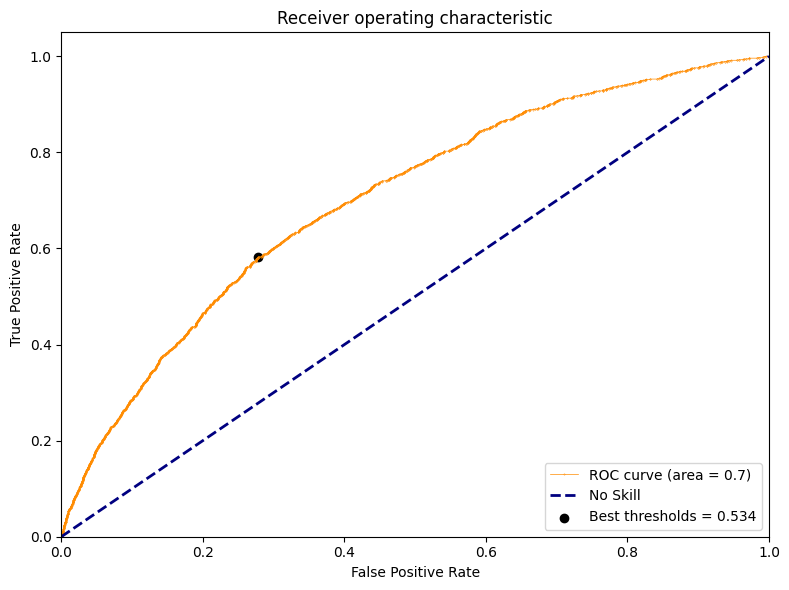

In [11]:
predictions = grid.predict_proba(X_test)[:, 1]

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

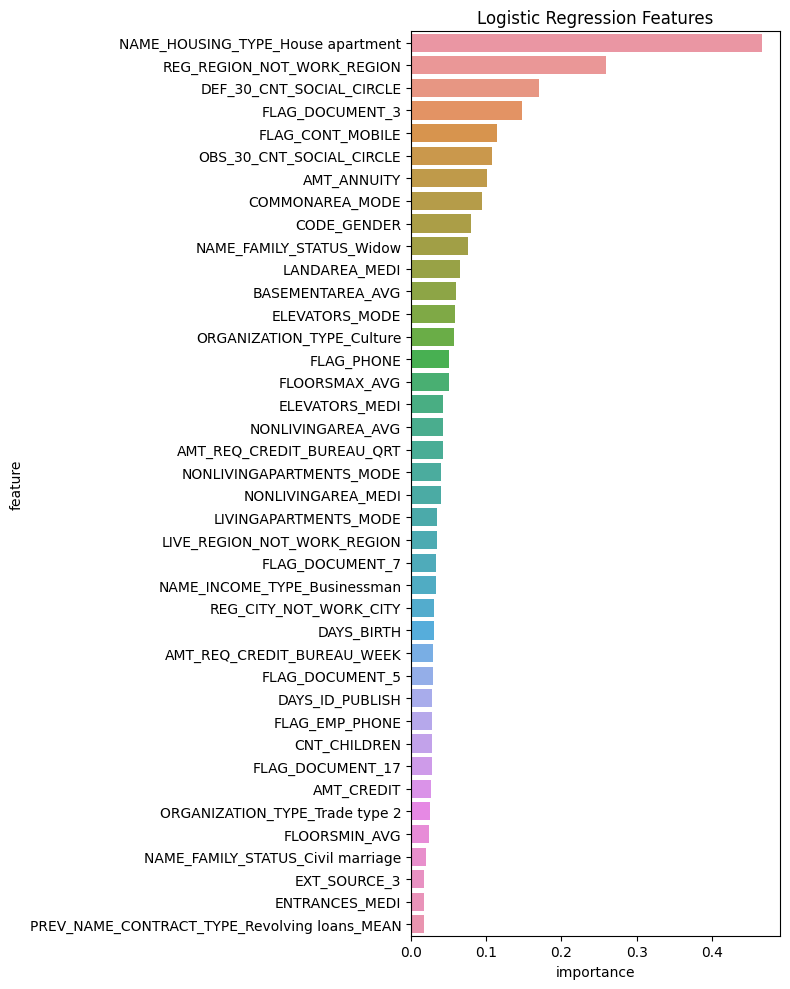

In [12]:
importance_df = pd.DataFrame()
importance_df["feature"] = feats
importance_df["importance"] = np.abs(grid.best_estimator_['logisticregression'].coef_[0])

title = 'Logistic Regression Features'
utils.display_importances(importance_df, title)

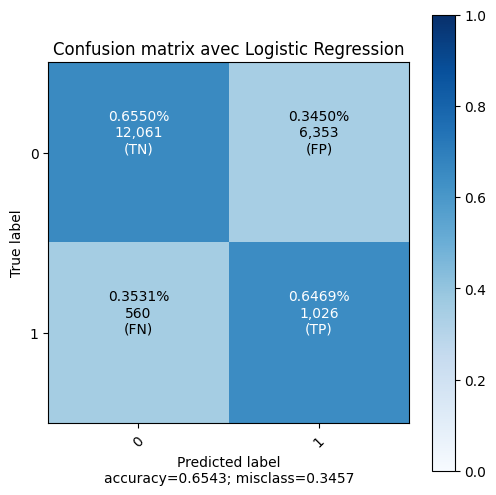

In [13]:
cm = confusion_matrix(y_test, grid.predict(X_test))
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

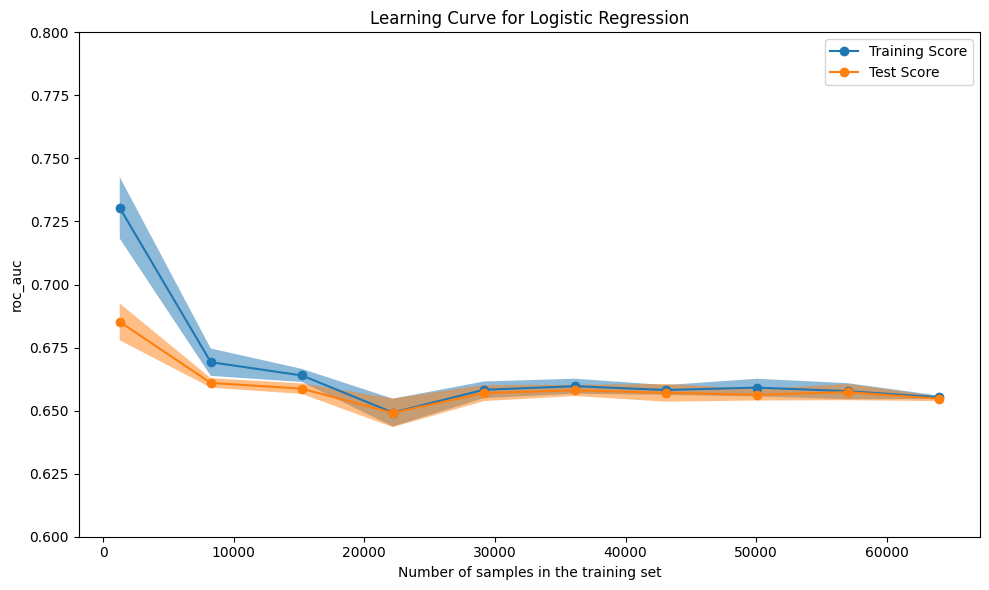

In [14]:
utils.plot_learning_curve(X_train, y_train, grid.best_estimator_)

## Enregistrement params/metrics/artefacts avec MLFlow

In [15]:
# avant cela nous allons reconstruire le dataset pour savoir le train et le test
def artifact_df(X_training, y_training, X_test, y_test, feats):
    df_train = pd.DataFrame(X_training, columns=feats)
    df_train['target'] = y_training
    df_train.to_csv('train_data.csv')

    df_test = pd.DataFrame(X_test, columns=feats)
    df_test['target'] = y_test
    df_test.to_csv('test_data.csv')

    return None

In [16]:
# Création d'une fonction personnalisée pour effectuer des prédictions en fonction d'un seuil
class CustomModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def predict(self, context, model_input):
        # Prédiction personnalisée avec le paramètre threshold
        probabilities = self.model.predict_proba(model_input)
        predictions = (probabilities[:, 1] >= self.threshold).astype(int)
        return predictions
    
    def predict_proba(self, context, model_input):
        return self.model.predict_proba(model_input)

C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:145: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data con

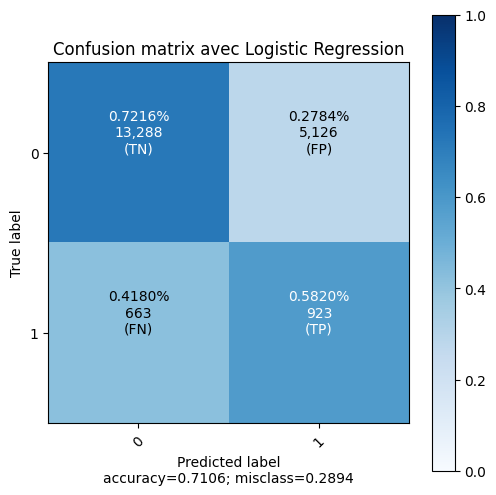

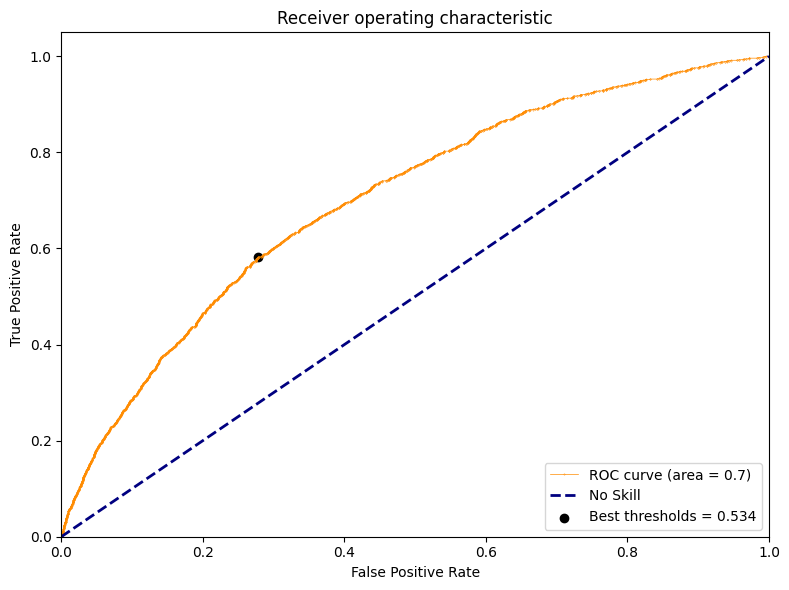

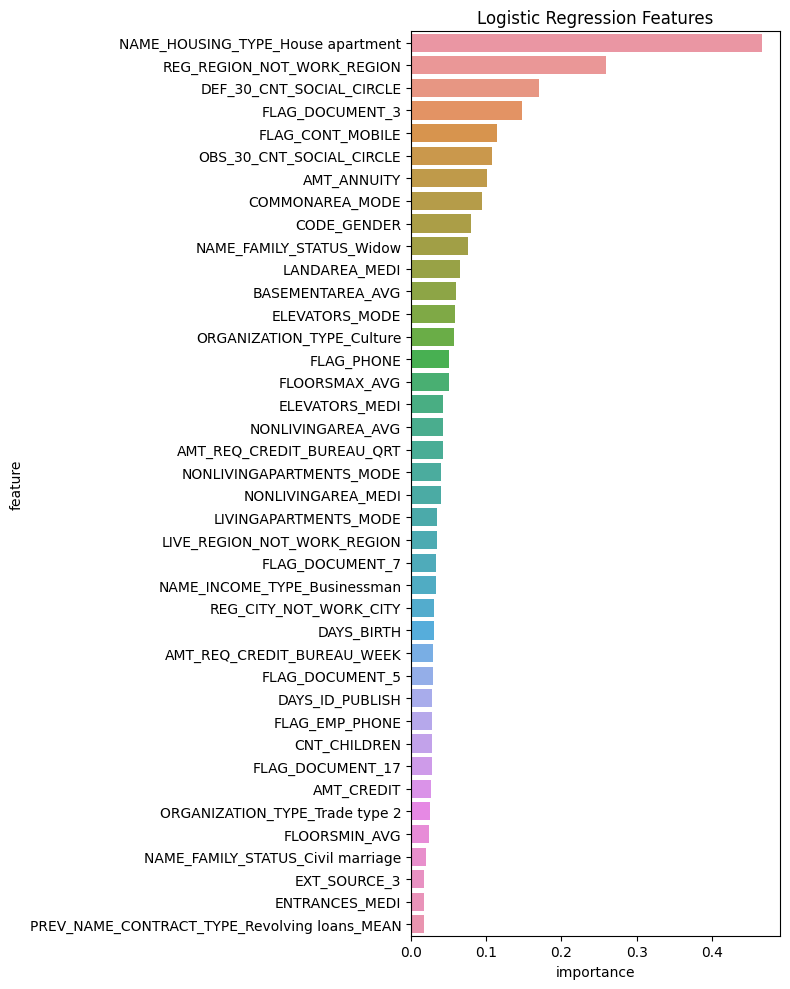

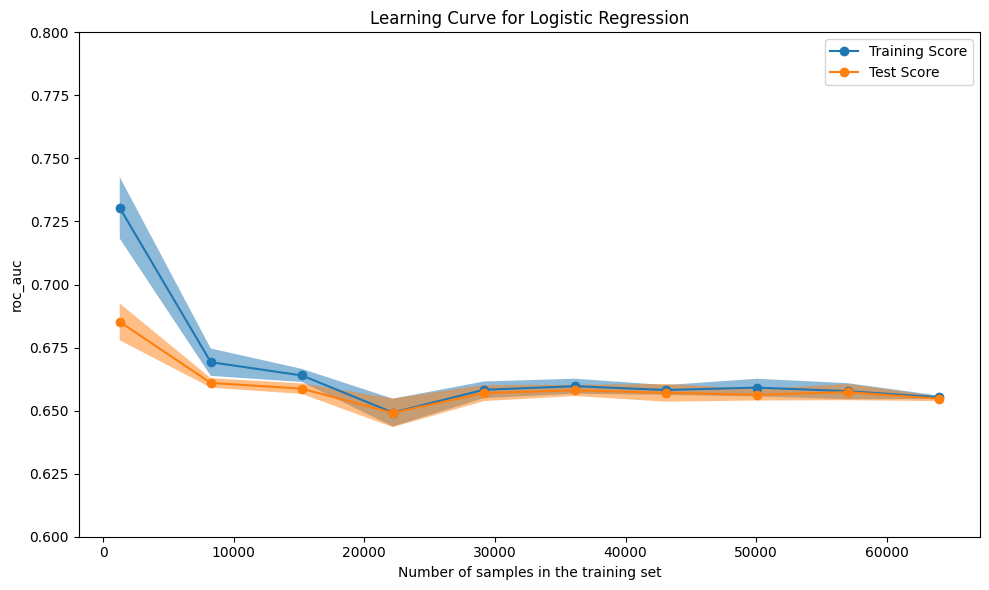

In [27]:
run_description = """
### Data
30% du dataset total (en terme de client)
Sélection de feature : condition sur la variance
                       Kbest (k=100) basé sur mutual_info_classif
Imputation simple : float --> mean
                    int   --> most frequent
Standard scaler pour vars continues

### Modèle
logistic regression paramétrer avec GridSearchCV
Threshold adapté au problème (cout FN = 10 * cout FP)
"""
run_name = 'LogisticRegressionThresholded'

with mlflow.start_run(run_name=run_name, description=run_description):

    # Enregistrement de plusieurs paramètres sous forme d'un dictionnaire
    params = {}
    params['MODEL_NAME'] = 'LogisticRegression'
    params['PARAMS_CV'] = b_params
    params['THRESHOLD'] = best_thresh
    params['BETA'] = 10
    params['TRAIN_SIZE'] = len(X_train)
    params['TEST_SIZE'] = len(X_test)
    params['SEED'] = 42
    mlflow.log_params(params)

    # On note le moment du début de l'expérience pour mesurer la durée de l'entraînement
    start = time.time()

    # Initialisation du modèle
    params = dict(logisticregression__tol=0.1, **b_params)
    pred_pipe_LR = make_pipeline(preprocessor,
                    LogisticRegression())
    pred_pipe_LR.set_params(**params)
    signature = infer_signature(X_train, y_train)

    # Entraînement du modèle
    pred_pipe_LR.fit(X_train, y_train)

    training_time = time.time() - start

    # # Enregistrement du modèle
    
    # Appliquez le seuil de prédiction souhaité avec votre fonction personnalisée
    custom_threshold = best_thresh  # Définissez ici la valeur de threshold souhaitée
    custom_model = CustomModelWrapper(pred_pipe_LR, threshold=custom_threshold)
    
    predictions = custom_model.predict(None, X_test)
    predictions_proba = pred_pipe_LR.predict_proba(X_test)[:, 1]

    # Enregistrez le modèle avec le seuil ajusté dans MLflow
    mlflow.pyfunc.log_model(
    python_model=custom_model,  
    artifact_path="mlflow_LR_with_threshold",  
    signature=signature
    )
    
    # Enregistrement du modèle avec joblib
    joblib.dump(pred_pipe_LR, 'LR_with_threshold.joblib')

    # Enregistrement de plusieurs métriques sous forme d'un dictionnaire
    metrics = {}
    metrics['Auc'] = roc_auc_score(y_test, predictions_proba)
    metrics['Fbeta'] = fbeta_score(y_test, predictions, beta=10)
    metrics['Precision'] = precision_score(y_test, predictions)
    metrics['Recall'] = recall_score(y_test, predictions)
    metrics['Accuracy'] = accuracy_score(y_test, predictions)
    metrics['Training Time'] = training_time
    mlflow.log_metrics(metrics)

    # Enregistrement de la matrice de confusion
    cm = confusion_matrix(y_test, predictions)
    title = 'Confusion matrix avec Logistic Regression'
    utils.plot_confusion_matrix(cm, ['0', '1'], title)
    mlflow.log_artifact('matrix.png')

    # Enregistrement courbe ROC
    utils.plot_roc_auc(y_test, predictions_proba)
    mlflow.log_artifact('roc_auc_curve.png')

    # Enregistrement features importance du modèle
    importance_df = pd.DataFrame()
    importance_df["feature"] = feats
    importance_df["importance"] = np.abs(pred_pipe_LR['logisticregression'].coef_[0])

    title = 'Logistic Regression Features'
    utils.display_importances(importance_df, title)
    mlflow.log_artifact('features_importances.png')

    # Enregistrement Learning curve
    utils.plot_learning_curve(X_train, y_train, pred_pipe_LR)
    mlflow.log_artifact('learning_curve.png')
    
    # # Enregistrement des datasets train et test
    # artifact_df(X_train, y_train, X_test, y_test, feats)
    # mlflow.log_artifact('train_data.csv')
    # mlflow.log_artifact('test_data.csv')
      

In [18]:
idx = [] 
for (i, j, k) in zip(y_test.index, y_test.values, predictions):
    if j != k:
        idx.append(i)

## Feature importance with LIME

In [19]:
cat_features = [i for i, c in enumerate(X.columns) if X.dtypes[i]!='float64']
class_names = ['accordé', 'refusé']

X_smpl = X.sample(10000)
X_smpl_tr = grid.best_estimator_.named_steps['columntransformer'].transform(X_smpl)

explainer = lime_tabular.LimeTabularExplainer(X_smpl_tr, mode="classification",
                                              class_names=class_names,
                                              feature_names=X.columns,
                                              categorical_features=cat_features
                                             )

In [20]:
idx = random.randint(1, len(X_test))

X_test_tr = grid.best_estimator_.named_steps['columntransformer'].transform(X_test.iloc[[idx]])
predict_fn = grid.best_estimator_.named_steps['logisticregression'].predict_proba


print("Prediction : ", class_names[grid.predict(X_test.iloc[[idx]])[0]])
print("Actual :     ", class_names[y_test.iloc[idx]])

explanation = explainer.explain_instance(X_test_tr[0], predict_fn,
                                         num_features=15)

explanation.show_in_notebook()

Prediction :  refusé
Actual :      accordé


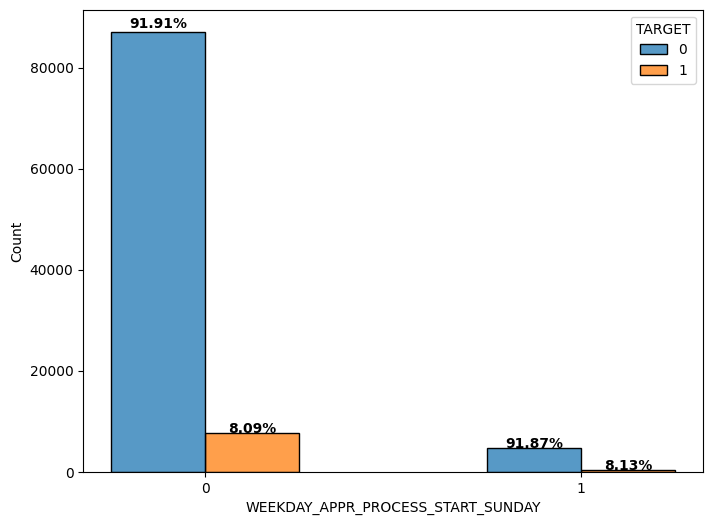

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['WEEKDAY_APPR_PROCESS_START_SUNDAY', 'TARGET']]
sns.histplot(data=data, ax=ax, x='WEEKDAY_APPR_PROCESS_START_SUNDAY', hue='TARGET', multiple='dodge', discrete=True, shrink=0.5)
ax.set_xticks([0, 1])

a = [p.get_height() for p in ax.patches]
pourcentage = [a[0]/(a[0] + a[2]), a[1]/(a[1] + a[3]), a[2]/(a[0] + a[2]), a[3]/(a[1] + a[3])]
pourcentage = [np.round(100*i, 2) for i in pourcentage]

for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01,
             str(pourcentage[i])+'%',
             ha='center',
             weight='bold')
    
# pouvoir choisir quelle variable plot, et sur quel jeu de donnée (tout ou un cluster lié au client)

<AxesSubplot: xlabel='DAYS_EMPLOYED_PERC', ylabel='Count'>

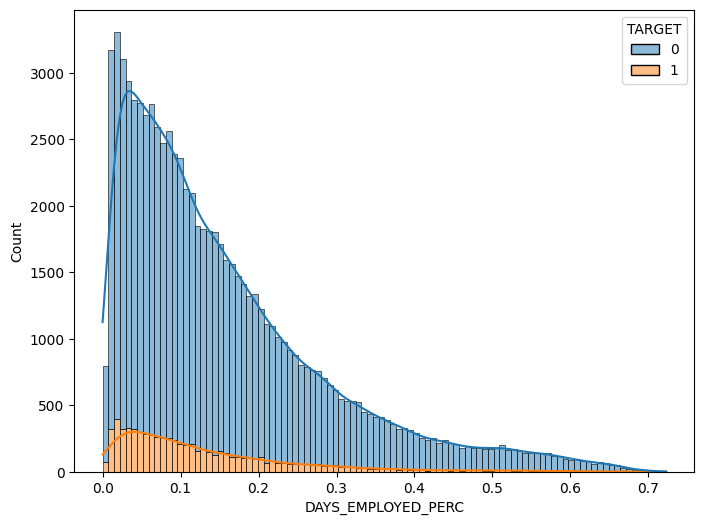

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['DAYS_EMPLOYED_PERC', 'TARGET']]
sns.histplot(data=data, ax=ax, x='DAYS_EMPLOYED_PERC', hue='TARGET', multiple='stack', kde=True)
#ax.set_xlim(0, 100)

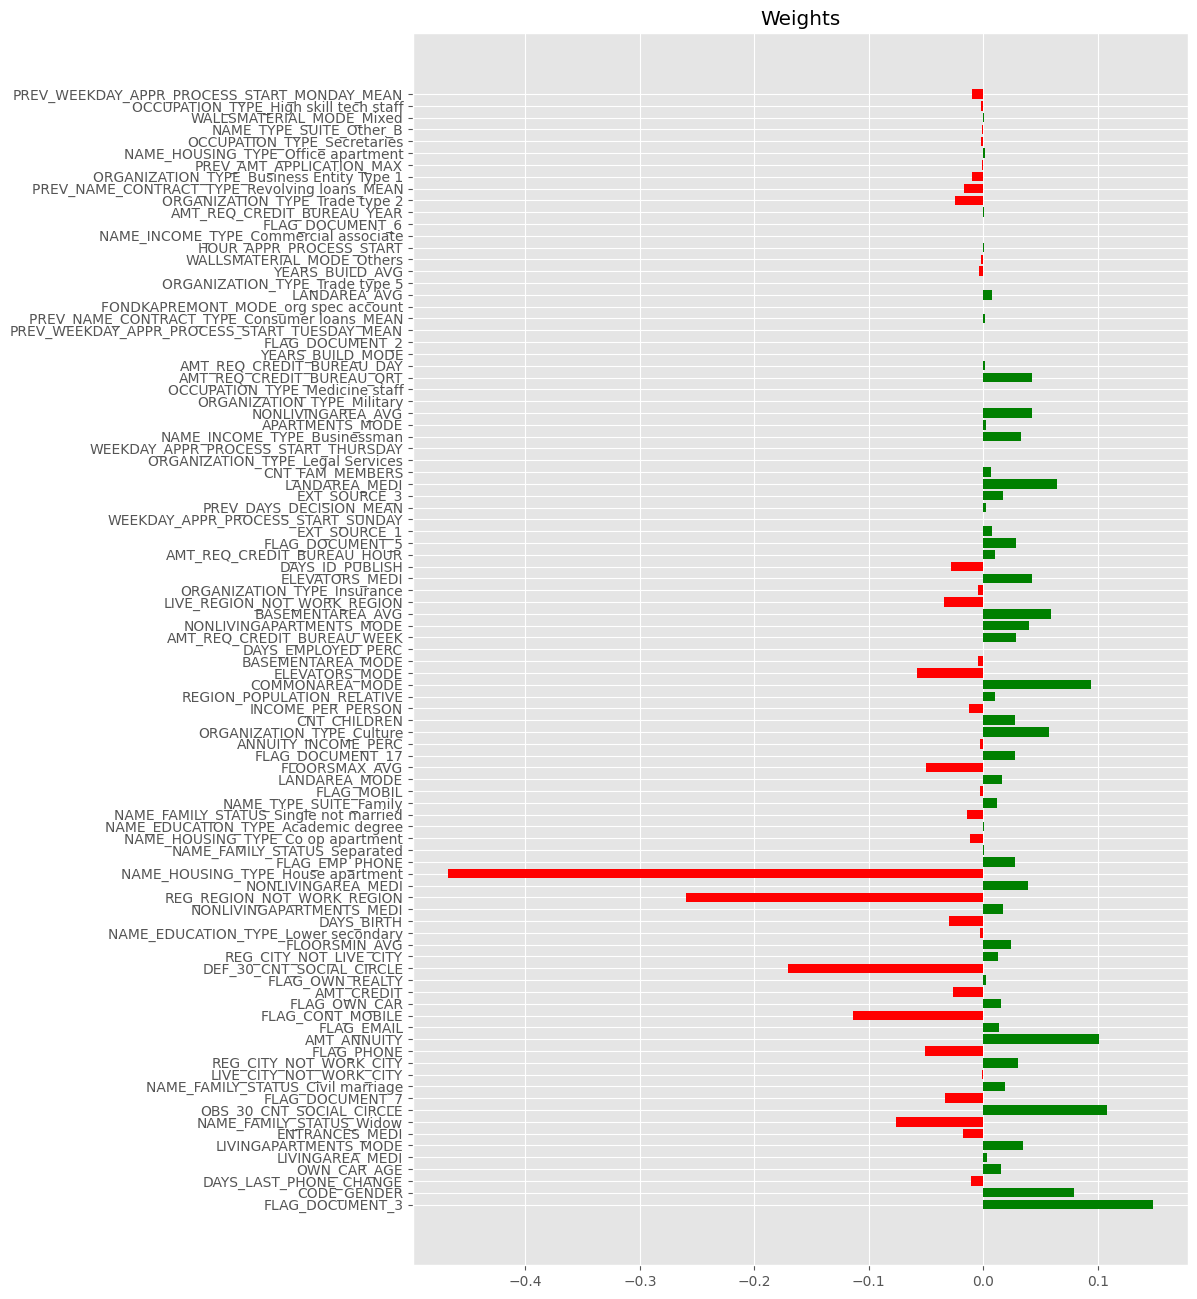

In [23]:
coefs = grid.best_estimator_['logisticregression'].coef_[0]
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(10,16))
    plt.barh(range(len(coefs)), coefs, color=["red" if coef<0 else "green" for coef in coefs])
    plt.yticks(range(len(coefs)), X.columns);
    plt.title("Weights")

## Analyse data drift avec Evidently